# Lecture 1.1: Intro to qiskit
from IBM Quantum Computing QGSS2024

## Qiskit Patterns:
1. Map problem to quantum circuits and operators
2. Optimize circuits for target hardware
3. Execute on target hardware
4. Postprocess results

### Step 1. Map problem to quantum circuits and operators
*Build a circuit with Qiskit SDK*

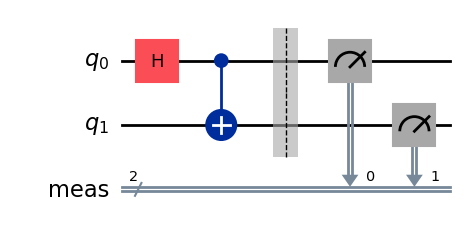

In [4]:
# 1. Import qiskit
from qiskit import QuantumCircuit, QuantumRegister # type: ignore

# 2. Initialize a register of qubits
qubits = QuantumRegister(2, name="q")

# 3. Add the qubits to a circuit
circuit = QuantumCircuit(qubits)

q0, q1 = qubits

# 4. Perform operations on those qubits
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

circuit.draw("mpl")

### 2. Optimize circuits for target hardware

#### 2.1 Transpile 
*Transpile a circuit with Qiskit SDK*

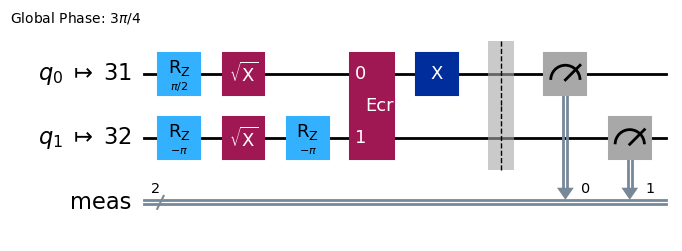

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# 1. Choose which device backend you want to target
backend = service.backend("ibm_osaka")

# 2. Create a preset staged pass manager with your desired optimization level
## higher optimization level is better transpile abstract circuit to ISA circuit, but more delay occur
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# 3. Run the staged pass manager on the circuit
isa_circuit = pass_manager.run(circuit)

isa_circuit.draw("mpl", idle_wires=False)

#### 2.2 Simulation
*Simulation a small circuit with Qiskit Runtime Service*

In [6]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Run the sampler job locally using FakeManilaV2
fake_backend = FakeManilaV2()
fake_pass_manager = generate_preset_pass_manager(backend=fake_backend, optimization_level=1)
fake_isa_circuit = fake_pass_manager.run(circuit)

# You can use a fixed seed to get fixed results: fake_machine implement quantum state -> probabilistic state (via random library)
fake_options = {"simulator": {"seed_simulator": 42}}
fake_sampler = Sampler(backend=fake_backend, options=fake_options)

fake_result = fake_sampler.run([fake_isa_circuit]).result()

/var/folders/_1/vyxw8wlj1wn0fhb6pl64k4lm0000gn/T/ipykernel_88531/825108695.py:11: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  fake_sampler = Sampler(backend=fake_backend, options=fake_options)


### 3. Execute on target hardware

Qiskit provide two-type of Primitive: Sampler and Estimator

#### 3.1 Sampler

*To run a circuit on quantum hardware*

In [8]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import SamplerV2 as Sampler

# 1. Initialize the Qiskit Runtime service
service = QiskitRuntimeService()

# 2. Choose a hardware backend
## It's a good option to select device more comfortable -> least_busy()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)


n_qubits = 127
mat = np.real(random_hermitian(n_qubits, seed=42))
circuit = IQP(mat)
circuit.measure_all()

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pass_manager.run(circuit)

# 3. Initialize a Qiskit Runtime primitive with your chosen backend 
sampler = Sampler(backend)

# 4. Invoke the primitive with your circuit
job = sampler.run([isa_circuit])
result = job.result()

#### 3.2 Estimator

*To run a circuit on quantum hardware*

In [19]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# 1. Initialize the Qiskit Runtime service
# service = QiskitRuntimeService()

# 2. Choose a hardware backend
## It's a good option to select device more comfortable -> least_busy()
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

n_qubits = 127

mat = np.real(random_hermitian(n_qubits, seed=42))
circuit = IQP(mat)
circuit.measure_all()

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pass_manager.run(circuit)

# 3. Initialize a Qiskit Runtime primitive with your chosen backend 
estimator = Estimator(backend)
observable = SparsePauliOp("Z" * n_qubits)
isa_observable = observable.apply_layout(isa_circuit.layout)

# 4. Invoke the primitive with your circuit
job = estimator.run([(isa_circuit, isa_observable)])
est_result = job.result()

print(f" > Expectation value: {est_result[0].data.evs}")
print(f" > Metadata: {est_result[0].metadata}")

### Interlude: Execution modes
- single job
- Batch: multiple concurrent jobs
- Session: iterative workload

In [ ]:
# Batch mode
from qiskit_ibm_runtime import SamplerV2 as Sampler, Batch

max_circuits = 100
all_partitioned_circuits = []

for i in range(0, len(circuits), max_circuits):
    all_partitioned_circuits.append(circuits[i : i + max_circuits])

jobs = []
start_idx = 0

with Batch(backend=backend):
    sampler = Sampler()
    for partitioned_circuits in all_partitioned_circuits:
        job = sampler.run(partitioned_circuits)
        jobs.append(job)

In [ ]:
# Session mode
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session

jobs= []

with Session(backend=backend):
    estimator = Sampler()
    for partitioned_circuits in all_partitioned_circuits:
        job = sampler.run(partitioned_circuits)
        jobs.append(job)

### 4. Postprocess results
1. visualize results
2. post-selection
3. circuit knitting